# GPyOpt: Modular Bayesian Optimization 

### Written by Javier Gonzalez, Amazon Reseach Cambridge


*Last updated, July 2017.*

In the [Introduction Bayesian Optimization GPyOpt](./GPyOpt_reference_manual.ipynb) we showed how GPyOpt can be used to solve optimization problems with some basic functionalities. The object 

```
GPyOpt.methods.BayesianOptimization
```
is used to initialize the desired functionalities, such us the acquisition function, the initial design or the model. In some cases we want to have control over those objects and we may want to replace some element in the loop without having to integrate the new elements in the base code framework. This is now possible through the modular implementation of the package using the

```
GPyOpt.methods.ModularBayesianOptimization
```

class. In this notebook we are going to show how to use the backbone of GPyOpt to run a Bayesian optimization algorithm in which we will use our own acquisition function. In particular we are going to use the Expected Improvement integrated over the jitter parameter. That is

$$acqu_{IEI}(x;\{x_n,y_n\},\theta) = \int acqu_{EI}(x;\{x_n,y_n\},\theta,\psi) p(\psi;a,b)d\psi $$
where $p(\psi;a,b)$ is, in this example, the distribution [$Beta(a,b)$](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.random.beta.html).

This acquisition is not available in GPyOpt, but we will implement and use in this notebook. The same can be done for other models, acquisition optimizers etc.

As usual, we start loading GPy and GPyOpt.

In [1]:
%pylab inline
import GPyOpt
import GPy

Populating the interactive namespace from numpy and matplotlib


In this example we will use the Branin function as a test case.

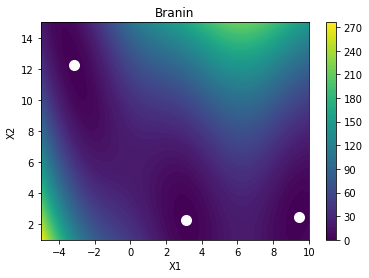

In [2]:
# --- Function to optimize
func  = GPyOpt.objective_examples.experiments2d.branin()
func.plot()

Because we are won't use the pre implemented wrapper, we need to create the classes for each element of the optimization. In total we need to create:

* Class for the **objective function**,

In [3]:
objective = GPyOpt.core.task.SingleObjective(func.f)

* Class for the **design space**,

In [4]:
space = GPyOpt.Design_space(space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-5,10)},
                                    {'name': 'var_2', 'type': 'continuous', 'domain': (1,15)}])

* Class for the **model type**,

In [5]:
model = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)

* Class for the **acquisition optimizer**,

In [6]:
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

* Class for the **initial design**,

In [7]:
initial_design = GPyOpt.experiment_design.initial_design('random', space, 5)

* Class for the **acquisition function**. Because we want to use our own acquisition, we need to implement a class to handle it. We will use the currently available Expected Improvement to create an integrated version over the jitter parameter. Samples will be generated using a beta distribution with parameters a and b as it is done using the default [numpy beta function](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.random.beta.html).

In [8]:
from GPyOpt.acquisitions.base import AcquisitionBase
from GPyOpt.acquisitions.EI import AcquisitionEI
from numpy.random import beta

class jitter_integrated_EI(AcquisitionBase):
    
    analytical_gradient_prediction = True
    
    def __init__(self, model, space, optimizer=None, cost_withGradients=None, par_a=1, par_b=1, num_samples= 10):
        super(jitter_integrated_EI, self).__init__(model, space, optimizer)
        
        self.par_a = par_a
        self.par_b = par_b
        self.num_samples = num_samples
        self.samples = beta(self.par_a,self.par_b,self.num_samples)
        self.EI = AcquisitionEI(model, space, optimizer, cost_withGradients)
    
    def acquisition_function(self,x):
        acqu_x = np.zeros((x.shape[0],1))       
        for k in range(self.num_samples):
            self.EI.jitter = self.samples[k]
            acqu_x +=self.EI.acquisition_function(x)           
        return acqu_x/self.num_samples
    
    def acquisition_function_withGradients(self,x):
        acqu_x      = np.zeros((x.shape[0],1))       
        acqu_x_grad = np.zeros(x.shape)
        
        for k in range(self.num_samples):
            self.EI.jitter = self.samples[k]       
            acqu_x_sample, acqu_x_grad_sample =self.EI.acquisition_function_withGradients(x) 
            acqu_x += acqu_x_sample
            acqu_x_grad += acqu_x_grad_sample           
        return acqu_x/self.num_samples, acqu_x_grad/self.num_samples

Now we initialize the class for this acquisition and we plot the histogram of the used samples to integrate the acquisition.

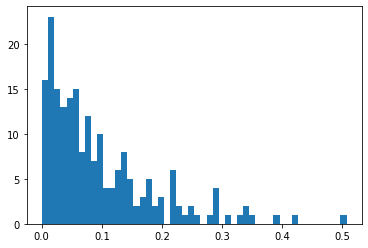

In [9]:
acquisition = jitter_integrated_EI(model, space, optimizer=aquisition_optimizer, par_a=1, par_b=10, num_samples=200)
xx = plt.hist(acquisition.samples,bins=50)

* Finally we create the class for the **type of evaluator**,

In [10]:
# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

With all the classes on place,including the one we have created for this example, we can now create the **Bayesian optimization object**.

In [11]:
bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design)

And we run the optimization.

In [12]:
max_iter  = 10                                            
bo.run_optimization(max_iter = max_iter) 

We plot the acquisition and the diagnostic plots.

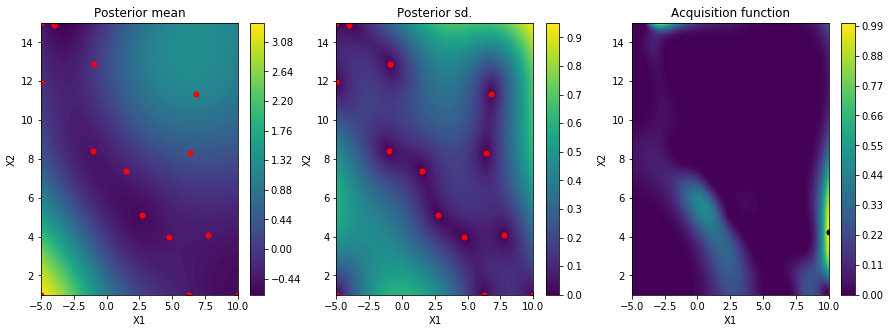

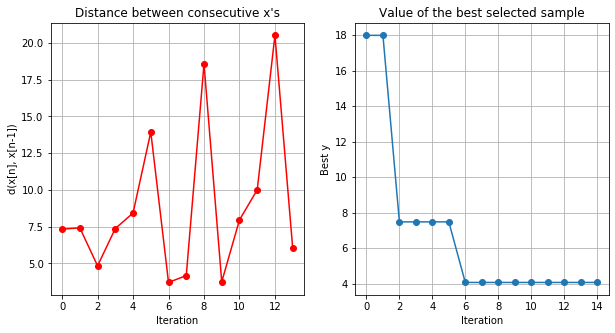

In [13]:
bo.plot_acquisition()
bo.plot_convergence()